In [1]:
# train.py

import os
import torch
import numpy as np
import warnings
import pickle
warnings.filterwarnings(action='ignore')

from data_loader import load_data_1m
from feature_calculations import (
    resample_data, calculate_MA_data, calculate_ema_bollinger_bands, calculate_rsi,
    calculate_macd, calculate_stochastic_oscillator, calculate_adx, calculate_atr,
    calculate_obv, calculate_williams_r, base_feature_fn, cyclic_encode_fn, log_transform,
    calculate_support_resistance_optimized
)
from strategies import BB_fitness_fn, BB_MACD_fitness_fn
from dataset import make_dataset, replace_nan_with_zero
from train_functions_inference_bi_2 import inference, fitness_fn, generation_valid, generation_test

from Prescriptor import Prescriptor
from Evolution.crossover import UniformCrossover, WeightedSumCrossover, DifferentialEvolutionOperator
from Evolution.mutation import MultiplyNormalMutation, MultiplyUniformMutation, AddNormalMutation, AddUniformMutation, ChainMutation, FlipSignMutation
from Evolution.mutation import RandomValueMutation
from Evolution.selection import RouletteSelection, TournamentSelection, ParetoLexsortSelection
from Evolution import Evolution




In [2]:
# Load Data
data_1m = load_data_1m('/root/daily/bit/data/1min_bitusdt.pkl')
# data_1m = data_1m.iloc[-200000:].reset_index(drop=True)
# data_1m = data_1m.iloc[3200000:].reset_index(drop=True)

In [3]:
# data_1m = data_1m.iloc[2000000:2700000].reset_index(drop=True)

In [4]:

data_1d = resample_data(data_1m, '1D')
data_1d['Close time'] = data_1d.index
data_1d = data_1d.reset_index(drop=True)

# Apply Feature Calculations
# For 1D Data
data_1d, ma_cols_1d, ma_cols_rel_1d = calculate_MA_data(data_1d, 60, 'EMA', '_1d')
data_1d, bb_cols_1d, bb_cols_rel_1d = calculate_ema_bollinger_bands(data_1d, 60, extra_str='_1d')
data_1d, rsi_cols_1d = calculate_rsi(data_1d, window=20, extra_str='_1d')
data_1d, macd_cols_1d = calculate_macd(data_1d, 20, 120, 60, extra_str='_1d')
data_1d, stoch_cols_1d = calculate_stochastic_oscillator(data_1d, 60, 20, extra_str='_1d')
data_1d, adx_cols_1d = calculate_adx(data_1d, 60, extra_str='_1d')
data_1d, atr_cols_1d = calculate_atr(data_1d, 60, extra_str='_1d')
data_1d, obv_cols_1d = calculate_obv(data_1d, extra_str='_1d')
data_1d, will_cols_1d = calculate_williams_r(data_1d, 60, extra_str='_1d')
data_1d, base_feature_1d = base_feature_fn(data_1d, extra_str='_1d')
data_1d, cyclice_encoding_1d = cyclic_encode_fn(data_1d, 'Close time', 'day_of_year')

# For 1M Data
data_1m, ma_cols, ma_cols_rel = calculate_MA_data(data_1m, 240, 'EMA')
data_1m, bb_cols, bb_cols_rel = calculate_ema_bollinger_bands(data_1m, 240)
data_1m, rsi_cols = calculate_rsi(data_1m, window=60)
data_1m, macd_cols = calculate_macd(data_1m, 60, 600, 240)
data_1m, stoch_cols = calculate_stochastic_oscillator(data_1m, 240, 60)
data_1m, adx_cols = calculate_adx(data_1m, 240)
data_1m, atr_cols = calculate_atr(data_1m, 240)
data_1m, obv_cols = calculate_obv(data_1m)
data_1m, will_cols = calculate_williams_r(data_1m, 240)
data_1m, base_feature = base_feature_fn(data_1m)
data_1m, cyclice_encoding = cyclic_encode_fn(data_1m, 'Open time')

# data_1m, short_ma_cols, short_ma_cols_rel = calculate_MA_data(data_1m, 60, 'EMA')
# data_1m, long_ma_cols, long_ma_cols_rel = calculate_MA_data(data_1m, 180, 'EMA')

data_1m, short_ma_cols, short_ma_cols_rel = calculate_MA_data(data_1m, 20, 'EMA')
data_1m, long_ma_cols, long_ma_cols_rel = calculate_MA_data(data_1m, 60, 'EMA')
data_1m, _, _ = calculate_ema_bollinger_bands(data_1m, 60)

# Prepare Feature Columns
drop_column = [
    'Open time', 'Close time', 'Quote asset volume', 'Ignore',
    'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume'
]
feature_column = (
    ma_cols_rel + bb_cols_rel + rsi_cols + macd_cols + stoch_cols +
    adx_cols + will_cols + base_feature + cyclice_encoding  # Excluding obv and atr
)
feature_column_1d = (
    ma_cols_rel_1d + bb_cols_rel_1d + rsi_cols_1d + macd_cols_1d + stoch_cols_1d +
    adx_cols_1d + will_cols_1d + base_feature_1d + cyclice_encoding_1d
)


# # Apply Log Transform
# for feature in feature_column:
#     data_1m[feature] = log_transform(data_1m[feature])

# for feature in feature_column_1d:
#     data_1d[feature] = log_transform(data_1d[feature])

data_1d['%D_20__1d'] = 0
data_1d['ADX_60__1d'] = 0


In [7]:
data_1m[feature_column[0]].min()

-30.383540592453055

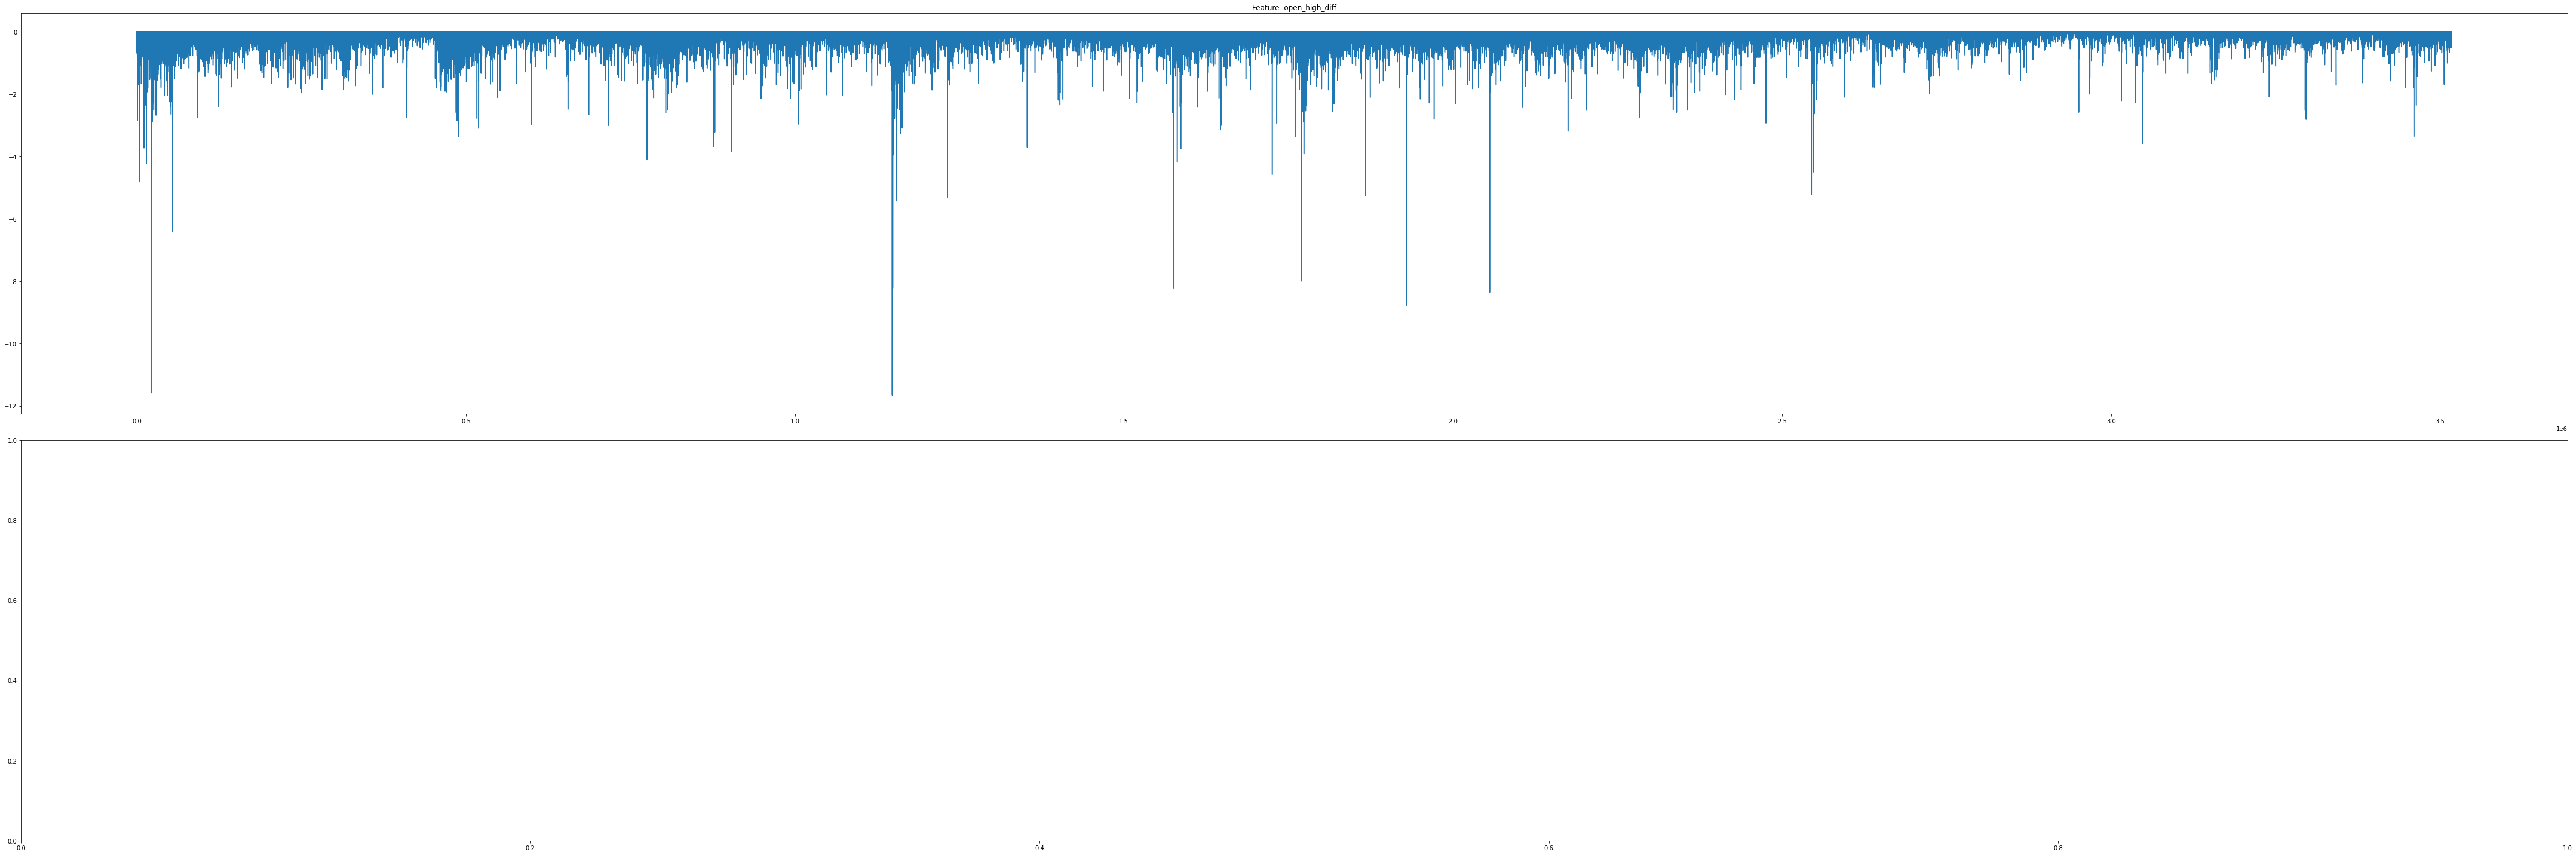

In [183]:
import matplotlib.pyplot as plt

feature_column_index = 11
fig, ax = plt.subplots(2, 1, figsize=(60, 20))

# Plot the feature column in the first subplot
ax[0].plot(data_1m[feature_column[feature_column_index]].values)
ax[0].set_title(f"Feature: {feature_column[feature_column_index]}")

# # Plot the 'Close' values in the second subplot
# ax[1].plot(data_1m['Close'].values)
# ax[1].set_title("Close Prices")

plt.tight_layout()
# plt.title(feature_column[feature_column_index])

In [184]:
feature_column[feature_column_index]

'open_high_diff'

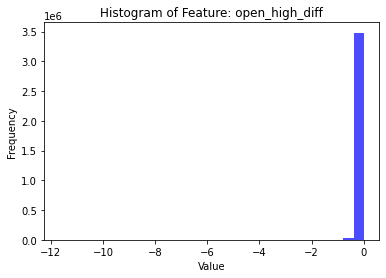

In [185]:
plt.hist(data_1m[feature_column[feature_column_index]].values, bins=30, alpha=0.7, color='blue')
plt.title(f"Histogram of Feature: {feature_column[feature_column_index]}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

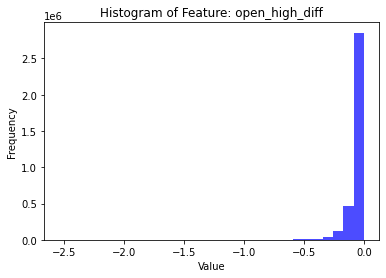

In [186]:
plt.hist(log_transform(data_1m[feature_column[feature_column_index]]).values, bins=30, alpha=0.7, color='blue')
plt.title(f"Histogram of Feature: {feature_column[feature_column_index]}")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()